In [1]:
# BLOCK 1
import pandas as pd
import os

# --- Define the path to your final, clean, and fast Parquet file ---
file_path = 'nsw_corpus_final.parquet'

print(f"Loading the final NSW corpus from: {file_path}")

if not os.path.exists(file_path):
    print(f"--- ERROR: File not found at '{file_path}' ---")
else:
    # --- Load the DataFrame using Pandas ---
    # Parquet is an extremely fast format to read.
    df_nsw = pd.read_parquet(file_path)
    print("--- Final NSW Dataset loaded successfully ---")

    # --- Initial Validation ---
    print("\n--- DataFrame Info ---")
    # Using memory_usage='deep' gives a more accurate report of the true memory footprint
    df_nsw.info(memory_usage='deep')

    print("\n--- First 5 Rows of the Dataset ---")
    print(df_nsw.head())

Loading the final NSW corpus from: nsw_corpus_final.parquet
--- Final NSW Dataset loaded successfully ---

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 119587 entries, 12 to 232559
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   version_id    119587 non-null  object
 1   type          119587 non-null  object
 2   jurisdiction  119587 non-null  object
 3   source        119587 non-null  object
 4   mime          119587 non-null  object
 5   date          118942 non-null  object
 6   citation      119587 non-null  object
 7   url           119587 non-null  object
 8   when_scraped  119587 non-null  object
 9   text          119587 non-null  object
dtypes: object(10)
memory usage: 8.4 GB

--- First 5 Rows of the Dataset ---
                                 version_id                 type  \
12  nsw_legislation:2009-07-06/act-1968-059  primary_legislation   
15  nsw_legislation:2021-07-01/act


--- EDA corpus composition analysis ---

Analysing the breakdown of document sources...

Poster asset: Document source distribution
------------------------------------------
source
nsw_caselaw        117371
nsw_legislation      2216
Name: count, dtype: int64


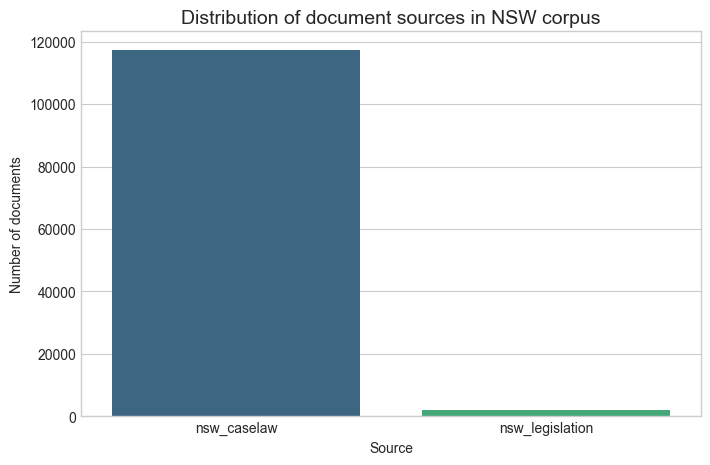

In [2]:
# BLOCK 2
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots appear inline in your Jupyter notebook
%matplotlib inline

print("\n--- EDA corpus composition analysis ---")

# --- Breakdown by source (legislation vs. caselaw) ---
print("\nAnalysing the breakdown of document sources...")
source_counts = df_nsw['source'].value_counts()

print("\nPoster asset: Document source distribution")
print("------------------------------------------")
print(source_counts)

# Plotting the result
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 5))
# Corrected sns.barplot call to remove the warning
sns.barplot(x=source_counts.index, y=source_counts.values, hue=source_counts.index, palette="viridis", legend=False)
plt.title('Distribution of document sources in NSW corpus', fontsize=14)
plt.ylabel('Number of documents')
plt.xlabel('Source')
plt.show()


Analyzing the breakdown of document types...

Poster asset: Document type distribution
----------------------------------------
type
decision                 117371
primary_legislation        1418
secondary_legislation       798
Name: count, dtype: int64


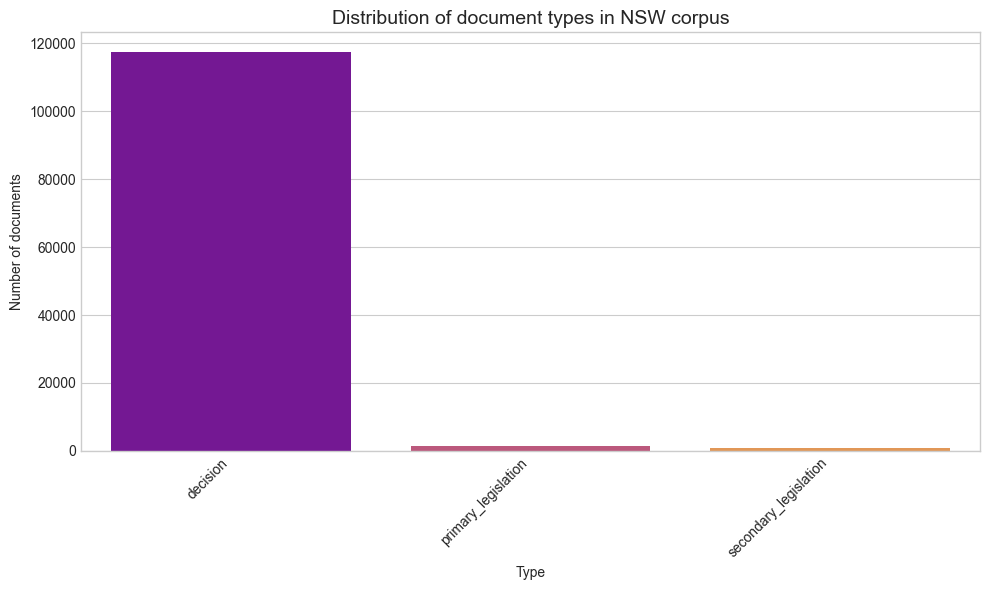

In [3]:
# BLOCK 3
# --- Breakdown by type ---
print("\nAnalyzing the breakdown of document types...")
type_counts = df_nsw['type'].value_counts()

print("\nPoster asset: Document type distribution")
print("----------------------------------------")
print(type_counts)

plt.figure(figsize=(10, 6))
# Corrected sns.barplot call to remove the warning
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index, palette="plasma", legend=False)
plt.title('Distribution of document types in NSW corpus', fontsize=14)
plt.ylabel('Number of documents')
plt.xlabel('Type')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()


Calculating word counts for all documents (this may take a moment)...

Poster asset: Overall document length statistics
------------------------------------------------
count    119587.000000
mean       6703.296805
std        8696.778770
min          48.000000
25%        2230.000000
50%        4316.000000
75%        8061.000000
max      414869.000000
Name: word_count, dtype: float64

Generating poster asset: comparison of document lengths by source...


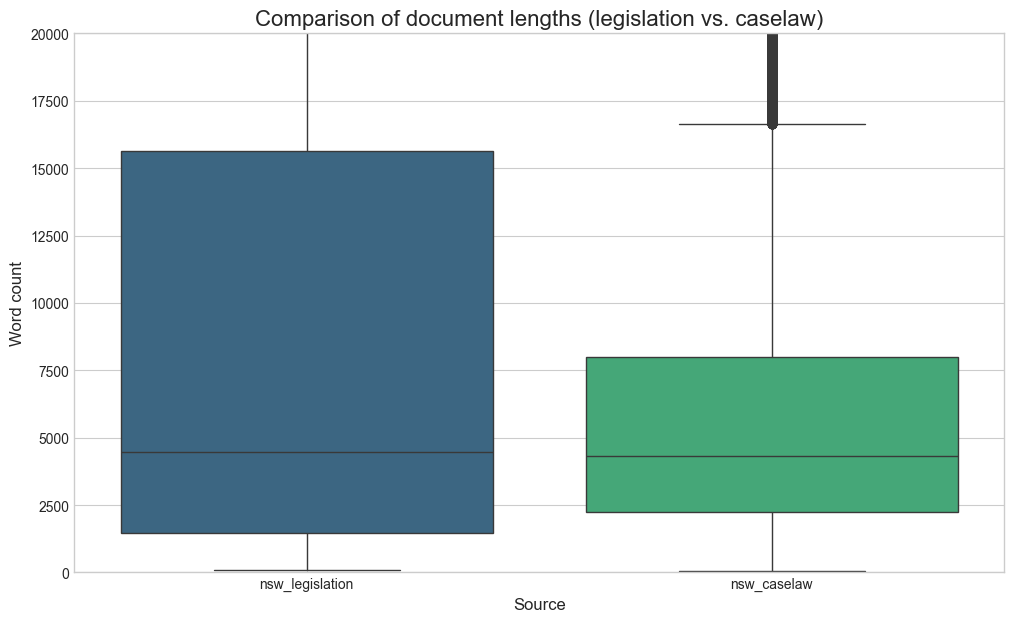

In [14]:
# BLOCK 4

# --- Document length analysis ---
print("\nCalculating word counts for all documents (this may take a moment)...")
# Since the 'text' column is clean, we can create the word_count column from it.
if 'word_count' not in df_nsw.columns:
    df_nsw['word_count'] = df_nsw['text'].str.split().str.len()

print("\nPoster asset: Overall document length statistics")
print("------------------------------------------------")
print(df_nsw['word_count'].describe())

# --- Comparing document lengths by source ---
print("\nGenerating poster asset: comparison of document lengths by source...")
plt.figure(figsize=(12, 7))
# Corrected sns.boxplot call to remove the warning
sns.boxplot(x='source', y='word_count', data=df_nsw, hue='source', palette="viridis", legend=False)
plt.title('Comparison of document lengths (legislation vs. caselaw)', fontsize=16)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Word count', fontsize=12)
plt.ylim(0, 20000) # Set a sensible limit to zoom in on the main distribution
plt.grid(True)
plt.show()

In [5]:
# BLOCK 5

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import pandas as pd

# Download the list of stopwords from NLTK (only needs to be done once)
# This try/except block prevents an error if it's already downloaded
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

print("\n--- EDA Textual Content and Jargon Analysis ---")

# --- 1. Most Common Words and Phrases (N-grams) ---
print("\nCalculating the most common words and phrases...")

# Get the English stop words list
stop_words_list = stopwords.words('english')
# Add custom legal-specific stop words to filter out noise
custom_stop_words = ['section', 'act', 'regulation', 'subregulation', 'clause', 'subclause', 
                     'nsw', 'part', 'schedule', 'legislation', 'government', 'gazette', 
                     'order', 'form', 'authority', 'proclaimed', 'commencement', 'court',
                     'application', 'commission', 'tribunal', 'appeal', 'costs', 'respondent']
stop_words_list.extend(custom_stop_words)

# --- Unigram (Single Word) Analysis ---
# We use the 'text' column as it's the primary content from the clean dataset
unigram_vectorizer = CountVectorizer(stop_words=stop_words_list, max_features=25)
unigram_counts = unigram_vectorizer.fit_transform(df_nsw['text'])
unigram_freq = pd.Series(
    unigram_counts.toarray().sum(axis=0), 
    index=unigram_vectorizer.get_feature_names_out()
).sort_values(ascending=False)

print("\nPoster Asset: Top 25 Most Frequent Words (Jargon)")
print("-------------------------------------------------")
print(unigram_freq)




--- EDA Textual Content and Jargon Analysis ---

Calculating the most common words and phrases...

Poster Asset: Top 25 Most Frequent Words (Jargon)
-------------------------------------------------
mr             4110276
evidence       2413606
would          2163692
may            1803468
made           1789704
plaintiff      1634746
applicant      1576089
defendant      1337515
decision       1303451
said           1285918
time           1281018
case           1219017
proceedings    1202600
also           1150394
whether        1086360
person         1083964
one            1000553
first           970368
judgment        962289
ltd             955816
ms              933013
pty             856005
development     836479
orders          831201
matter          796814
dtype: int64


In [6]:
# BLOCK 6

# --- Bigram Analysis ---
print("\n--- Running Bigram Analysis ---")

# The 'min_df=10' parameter is the fix to prevent the MemoryError
bigram_vectorizer = CountVectorizer(stop_words=stop_words_list, ngram_range=(2, 2), max_features=25, min_df=10)
bigram_counts = bigram_vectorizer.fit_transform(df_nsw['text'])
bigram_freq = pd.Series(
    bigram_counts.toarray().sum(axis=0), 
    index=bigram_vectorizer.get_feature_names_out()
).sort_values(ascending=False)

print("\nPoster Asset: Top 25 Most Frequent Two-Word Phrases")
print("-----------------------------------------------------")
print(bigram_freq)


--- Running Bigram Analysis (Corrected for Memory) ---

Poster Asset: Top 25 Most Frequent Two-Word Phrases
-----------------------------------------------------
pty ltd                    689632
new south                  451506
south wales                449930
judgment decision          229923
pty limited                164438
cross examination          158227
primary judge              152302
first defendant            149796
file number                140182
trial judge                133840
may apply                  126538
statutory provisions       125359
non parole                 123152
gave evidence              120790
parole period              119799
intended use               117515
suppression orders         115049
prohibiting publication    115038
use material               114854
person using               114761
breach provision           114577
effort made                114549
material breach            114484
every effort               114478
may directed         

In [8]:
# BLOCK 7

import re

print("\n--- EDA data integrity and feature feasibility analysis ---")

# --- Data integrity check: duplicates ---
print("\nPerforming data integrity checks on the dataset...")
num_duplicates_id = df_nsw.duplicated(subset=['version_id']).sum()
# Corrected 'text_clean' to 'text'
num_duplicates_text = df_nsw.duplicated(subset=['text']).sum()

print("\nPoster asset: data integrity report")
print("---------------------------------------------")
print(f"Number of duplicate documents based on 'version_id': {num_duplicates_id}")
print(f"Number of duplicate documents based on 'text': {num_duplicates_text}")
if num_duplicates_id == 0 and num_duplicates_text == 0:
    print("--> Data integrity is high. No duplicates found in the dataset.")
else:
    print("--> Recommendation: Duplicates found. These should be removed before modelling.")


--- EDA data integrity and feature feasibility analysis ---

Performing data integrity checks on the dataset...

Poster asset: data integrity report
---------------------------------------------
Number of duplicate documents based on 'version_id': 0
Number of duplicate documents based on 'text': 0
--> Data integrity is high. No duplicates found in the dataset.


In [9]:
# BLOCK 8

# --- Feasibility check for knowledge graph: interconnectivity ---
print("\nAnalysing legislative interconnectivity (references to other Acts)...")
# Define a regex pattern to find references like "Crimes Act 1900"
act_pattern = r'\b\w[\w\s]+Act\s+\d{4}\b'

# Corrected 'text_clean' to 'text'
# .str.contains() returns a boolean Series (True if a doc contains the pattern)
docs_with_links = df_nsw['text'].str.contains(act_pattern, regex=True, case=False)
num_docs_with_links = docs_with_links.sum()
total_docs = len(df_nsw)
percentage_with_links = (num_docs_with_links / total_docs) * 100

print("\nPoster asset: knowledge graph feasibility")
print("-----------------------------------------")
print(f"Documents containing at least one reference to another Act: {num_docs_with_links:,}")
print(f"Percentage of corpus with potential graph connections: {percentage_with_links:.2f}%")


Analysing legislative interconnectivity (references to other Acts)...

Poster asset: knowledge graph feasibility
-----------------------------------------
Documents containing at least one reference to another Act: 98,939
Percentage of corpus with potential graph connections: 82.73%


In [10]:
# BLOCK 9

# --- Feasibility check for NER: penalty clauses ---
print("\nAnalysing for common entities (e.g., 'penalty units')...")
penalty_pattern = r'penalty units'

# Corrected 'text_clean' to 'text'
docs_with_penalties = df_nsw['text'].str.contains(penalty_pattern, regex=True, case=False)
num_docs_with_penalties = docs_with_penalties.sum()
percentage_with_penalties = (num_docs_with_penalties / total_docs) * 100

print("\nPoster asset: NER feasibility (penalties)")
print("-------------------------------------------")
print(f"Documents containing the phrase 'penalty units': {num_docs_with_penalties:,}")
print(f"Percentage of corpus mentioning penalty units: {percentage_with_penalties:.2f}%")


Analysing for common entities (e.g., 'penalty units')...

Poster asset: NER feasibility (penalties)
-------------------------------------------
Documents containing the phrase 'penalty units': 4,485
Percentage of corpus mentioning penalty units: 3.75%


In [11]:
# BLOCK 10

# --- Create a DataFrame for NSW Legislation only ---
df_legislation = df_nsw[df_nsw['source'] == 'nsw_legislation'].copy()

# --- Create a DataFrame for NSW Caselaw only ---
df_caselaw = df_nsw[df_nsw['source'] == 'nsw_caselaw'].copy()

# --- Verification Step ---
print("--- New DataFrames created successfully ---\n")
print(f"Shape of the Legislation DataFrame (df_legislation): {df_legislation.shape}")
print(f"Shape of the Caselaw DataFrame (df_caselaw): {df_caselaw.shape}\n")

print("--- First 3 rows of the Legislation DataFrame ---")
print(df_legislation.head(3))
print("\n--- First 3 rows of the Caselaw DataFrame ---")
print(df_caselaw.head(3))

--- New DataFrames created successfully ---

Shape of the Legislation DataFrame (df_legislation): (2216, 11)
Shape of the Caselaw DataFrame (df_caselaw): (117371, 11)

--- First 3 rows of the Legislation DataFrame ---
                                 version_id                 type  \
12  nsw_legislation:2009-07-06/act-1968-059  primary_legislation   
15  nsw_legislation:2021-07-01/act-2011-035  primary_legislation   
36  nsw_legislation:2017-06-08/act-1967-095  primary_legislation   

       jurisdiction           source       mime                 date  \
12  new_south_wales  nsw_legislation  text/html  2009-07-06 00:00:00   
15  new_south_wales  nsw_legislation  text/html  2021-07-01 00:00:00   
36  new_south_wales  nsw_legislation  text/html  2017-06-08 00:00:00   

                                             citation  \
12  Broken Hill to South Australian Border Railway...   
15              Government Advertising Act 2011 (NSW)   
36     Technical Education Trust Funds Act 1967 (

In [ ]:
# BLOCK 11

import os

# --- Define output directory ---
output_dir = 'nsw_subsets'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# --- File paths ---
leg_parquet_path = os.path.join(output_dir, 'nsw_legislation.parquet')
leg_jsonl_path = os.path.join(output_dir, 'nsw_legislation.jsonl')
case_parquet_path = os.path.join(output_dir, 'nsw_caselaw.parquet')
case_jsonl_path = os.path.join(output_dir, 'nsw_caselaw.jsonl')

# --- Save the Legislation DataFrame ---
print("\nSaving legislation data...")
# Save to Parquet format (fast and efficient)
df_legislation.to_parquet(leg_parquet_path)
print(f"-> Successfully saved legislation data to: {leg_parquet_path}")

# Save to JSON Lines format (.jsonl)
# orient='records' creates a list of dictionaries, one for each row.
# lines=True ensures each dictionary is written on a new line.
df_legislation.to_json(leg_jsonl_path, orient='records', lines=True)
print(f"-> Successfully saved legislation data to: {leg_jsonl_path}")


# --- Save the Caselaw DataFrame ---
print("\nSaving caselaw data...")
# Save to Parquet format
df_caselaw.to_parquet(case_parquet_path)
print(f"-> Successfully saved caselaw data to: {case_parquet_path}")

# Save to JSON Lines format (.jsonl)
df_caselaw.to_json(case_jsonl_path, orient='records', lines=True)
print(f"-> Successfully saved caselaw data to: {case_jsonl_path}")

print("\n--- All 4 files saved successfully. ---")

In [16]:
# BLOCK 12
import pandas as pd
import os

print("--- Loading filtered datasets ---")

# Define paths to the files we saved earlier
output_dir = 'nsw_subsets'
leg_parquet_path = os.path.join(output_dir, 'nsw_legislation.parquet')
case_parquet_path = os.path.join(output_dir, 'nsw_caselaw.parquet')

# Load the dataframes
try:
    df_legislation = pd.read_parquet(leg_parquet_path)
    df_caselaw = pd.read_parquet(case_parquet_path)
    print("-> Successfully loaded legislation and caselaw dataframes.")
except FileNotFoundError:
    print("-> ERROR: Parquet files not found. Please ensure the previous notebook block was run successfully.")
    # Stop execution if files are not found
    exit()



--- Loading filtered datasets ---
-> Successfully loaded legislation and caselaw dataframes.


In [17]:
# BLOCK 13
print("\n--- Creating a stratified sample for annotation ---")

# Define sample sizes
N_LEGISLATION_SAMPLES = 100
N_CASELAW_SAMPLES = 150
# Using a fixed random_state for reproducibility
RANDOM_STATE = 42

# Take a random sample from each dataframe
legislation_sample = df_legislation.sample(n=N_LEGISLATION_SAMPLES, random_state=RANDOM_STATE)
caselaw_sample = df_caselaw.sample(n=N_CASELAW_SAMPLES, random_state=RANDOM_STATE)

print(f"-> Sampled {len(legislation_sample)} documents from legislation.")
print(f"-> Sampled {len(caselaw_sample)} documents from caselaw.")

# Combine the samples into a single dataframe
df_for_annotation = pd.concat([legislation_sample, caselaw_sample])

# Shuffle the combined dataframe to mix the document types
df_for_annotation = df_for_annotation.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\n-> Created final annotation set with {len(df_for_annotation)} total documents.")

print("\n--- Step 3: Exporting data to .jsonl format for Doccano ---")

# Define the output file path
annotation_file_path = os.path.join(output_dir, 'annotation_sample.jsonl')

# Select only the 'text' column as required by Doccano's text classification/NER format
# and rename it to 'text' if it's not already named that (Doccano uses a 'text' key).
df_for_annotation_export = df_for_annotation[['text']]

# Save to .jsonl format
df_for_annotation_export.to_json(annotation_file_path, orient='records', lines=True)

print(f"-> Successfully saved data for annotation to: {annotation_file_path}")
print("\n--- Data preparation complete. You can now proceed to the annotation tool. ---")


--- Creating a stratified sample for annotation ---
-> Sampled 100 documents from legislation.
-> Sampled 150 documents from caselaw.

-> Created final annotation set with 250 total documents.

--- Step 3: Exporting data to .jsonl format for Doccano ---
-> Successfully saved data for annotation to: nsw_subsets\annotation_sample.jsonl

--- Data preparation complete. You can now proceed to the annotation tool. ---


In [13]:
# --- Final Poster Asset: Annotated Text Example ---
# This is a manually annotated example to illustrate the GOAL of your NER model.
print("\n\nPoster Asset: Annotated Text Example for NER")
print("-----------------------------------------------")
print("This example illustrates the target output of the future Named Entity Recognition model.\n")
print("""
Example Text:
"A person must not, in a public place, have in his or her possession a knife (other than a knife of a class prescribed by the regulations), except for the purposes of a lawful excuse. Maximum penalty: 20 penalty units or imprisonment for 2 years, or both. This section is a restatement of section 11C of the Summary Offences Act 1988 as in force immediately before 1 January 2008."

---

Annotated Entities:
- **OBLIGATION**: "must not"
- **LOCATION**: "public place"
- **OBJECT**: "knife"
- **PENALTY**: "20 penalty units"
- **PENALTY**: "imprisonment for 2 years"
- **LEGISLATION**: "Summary Offences Act 1988"
- **DATE**: "1 January 2008"
""")



Poster Asset: Annotated Text Example for NER
-----------------------------------------------
This example illustrates the target output of the future Named Entity Recognition model.


Example Text:
"A person must not, in a public place, have in his or her possession a knife (other than a knife of a class prescribed by the regulations), except for the purposes of a lawful excuse. Maximum penalty: 20 penalty units or imprisonment for 2 years, or both. This section is a restatement of section 11C of the Summary Offences Act 1988 as in force immediately before 1 January 2008."

---

Annotated Entities:
- **OBLIGATION**: "must not"
- **LOCATION**: "public place"
- **OBJECT**: "knife"
- **PENALTY**: "20 penalty units"
- **PENALTY**: "imprisonment for 2 years"
- **LEGISLATION**: "Summary Offences Act 1988"
- **DATE**: "1 January 2008"

